In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

In [41]:
# Set up paths to merged data files
merged_data_path = os.path.join(os.getcwd(), 'data', 'merged_data')
master_train_path = os.path.join(merged_data_path, 'master_train.csv')
master_forecast_path = os.path.join(merged_data_path, 'master_forecast.csv')

In [43]:
df_master_train = pd.read_csv(master_train_path, low_memory=False)
# Convert date column to datetime (CSV files don't preserve data types)
df_master_train['date'] = pd.to_datetime(df_master_train['date'])
df_master_train = df_master_train.convert_dtypes()
df_master_train.info()

df_master_forecast = pd.read_csv(master_forecast_path, low_memory=False)
df_master_forecast['date'] = pd.to_datetime(df_master_forecast['date'])
df_master_forecast = df_master_forecast.convert_dtypes()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341801 entries, 0 to 341800
Data columns (total 53 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   341801 non-null  datetime64[ns]
 1   articleId              341801 non-null  string        
 2   storeCount             341801 non-null  Int64         
 3   FSC_index              341783 non-null  Float64       
 4   sales_volume_index     341801 non-null  Float64       
 5   promo_id               43964 non-null   string        
 6   discountPct            43964 non-null   Float64       
 7   category               341801 non-null  string        
 8   mainProductGroup       341801 non-null  string        
 9   holidayEventIndicator  341801 non-null  Int64         
 10  workingDayIndicator    341801 non-null  Int64         
 11  holidayEventName       14219 non-null   string        
 12  doWName                341801 non-null  stri

MISSING DATA ANALYSIS
                  Missing Count  Missing Percentage
holidayEventName         327582           95.839977
promo_id                 297837           87.137545
discountPct              297837           87.137545
FSC_index                    18            0.005266


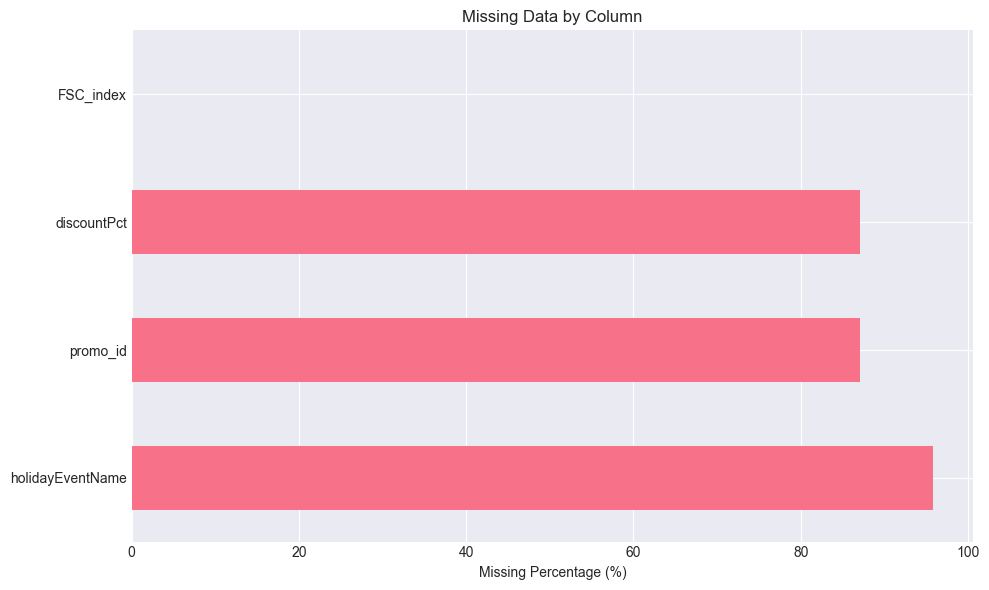

In [44]:
# Missing data analysis
missing_data = df_master_train.isnull().sum()
missing_pct = (missing_data / len(df_master_train)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("=" * 60)
print("MISSING DATA ANALYSIS")
print("=" * 60)
print(missing_df)

# Visualize missing data
if len(missing_df) > 0:
    plt.figure(figsize=(10, max(6, len(missing_df) * 0.4)))
    missing_df['Missing Percentage'].plot(kind='barh')
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Data by Column')
    plt.tight_layout()
    plt.show()

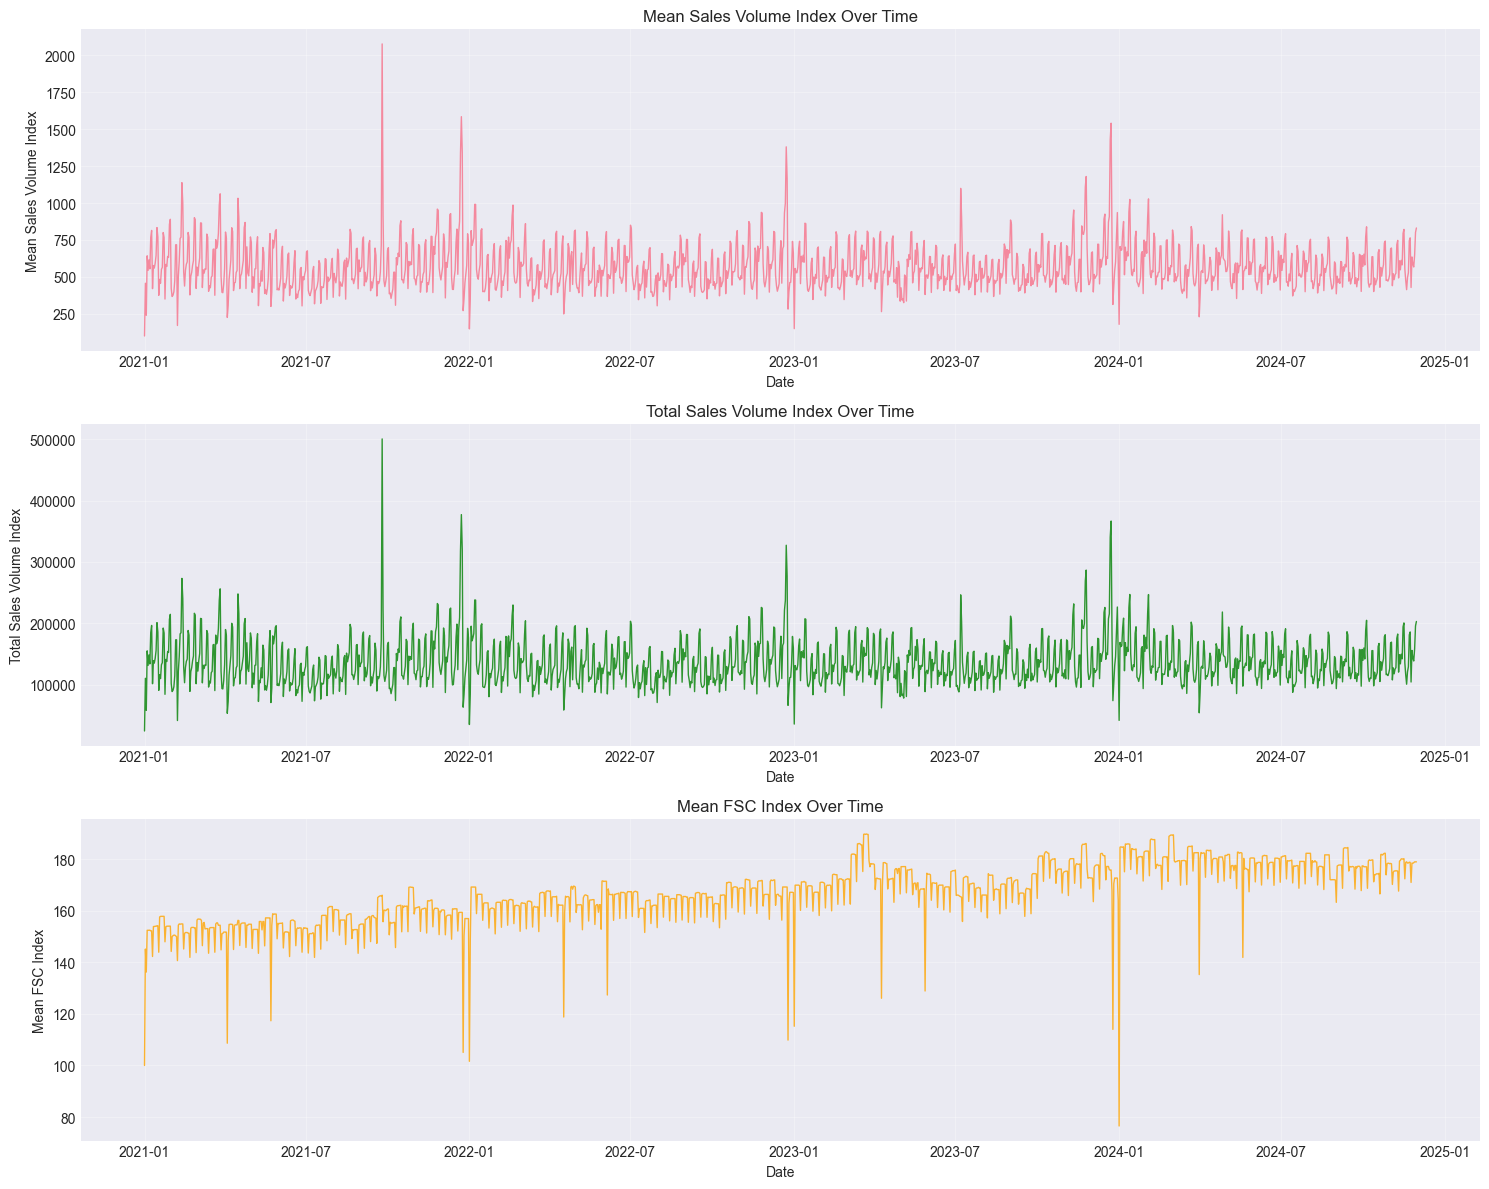

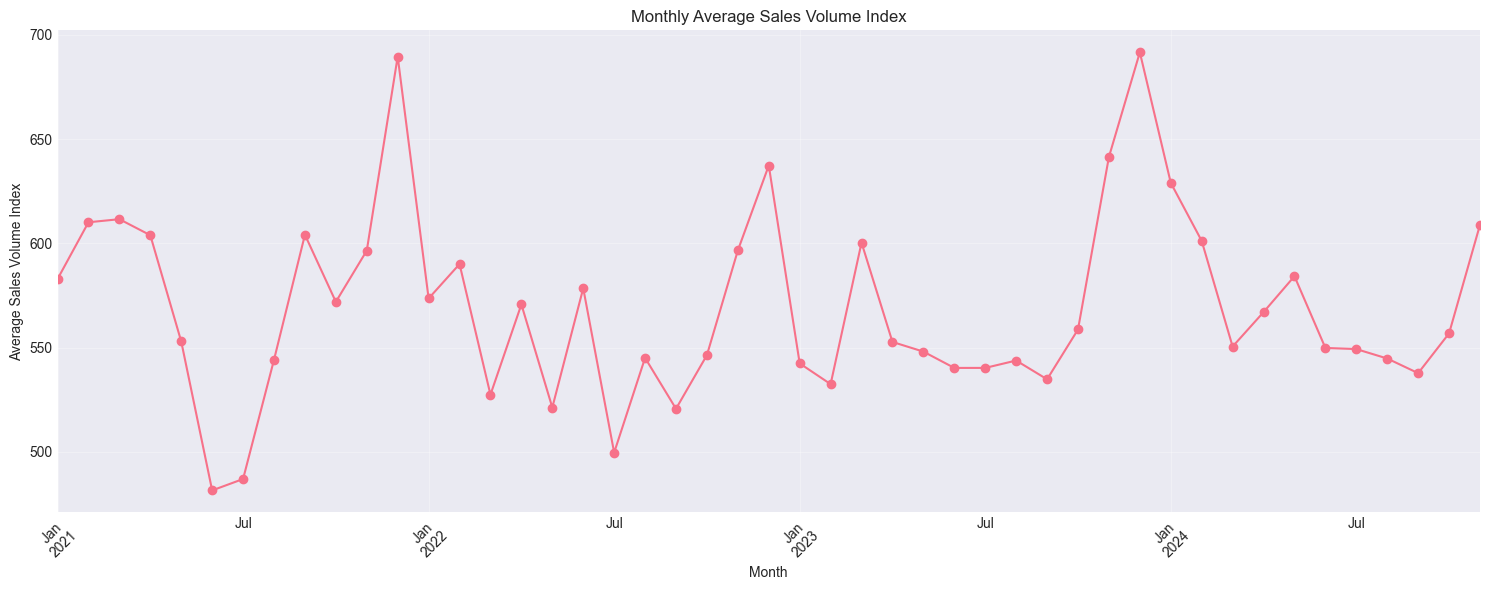

In [46]:
# Time series analysis - aggregate sales over time
daily_sales = df_master_train.groupby('date').agg({
    'sales_volume_index': ['mean', 'sum', 'std'],
    'FSC_index': 'mean'
}).reset_index()
daily_sales.columns = ['date', 'mean_sales', 'total_sales', 'std_sales', 'mean_fsc']

# Plot time series
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Mean sales over time
axes[0].plot(daily_sales['date'], daily_sales['mean_sales'], linewidth=1, alpha=0.8)
axes[0].set_title('Mean Sales Volume Index Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Mean Sales Volume Index')
axes[0].grid(True, alpha=0.3)

# Total sales over time
axes[1].plot(daily_sales['date'], daily_sales['total_sales'], linewidth=1, alpha=0.8, color='green')
axes[1].set_title('Total Sales Volume Index Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Sales Volume Index')
axes[1].grid(True, alpha=0.3)

# FSC index over time
axes[2].plot(daily_sales['date'], daily_sales['mean_fsc'], linewidth=1, alpha=0.8, color='orange')
axes[2].set_title('Mean FSC Index Over Time')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Mean FSC Index')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Monthly patterns
df_master_train['year_month'] = df_master_train['date'].dt.to_period('M')
monthly_sales = df_master_train.groupby('year_month')['sales_volume_index'].mean()

plt.figure(figsize=(15, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Average Sales Volume Index')
plt.xlabel('Month')
plt.ylabel('Average Sales Volume Index')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

PROMOTION IMPACT ANALYSIS
          sales_volume_index                           discountPct
                        mean   median      std   count        mean
has_promo                                                         
False                 394.03   288.22    752.6  297837        <NA>
True                 1756.75  1050.53  2375.22   43964        0.31


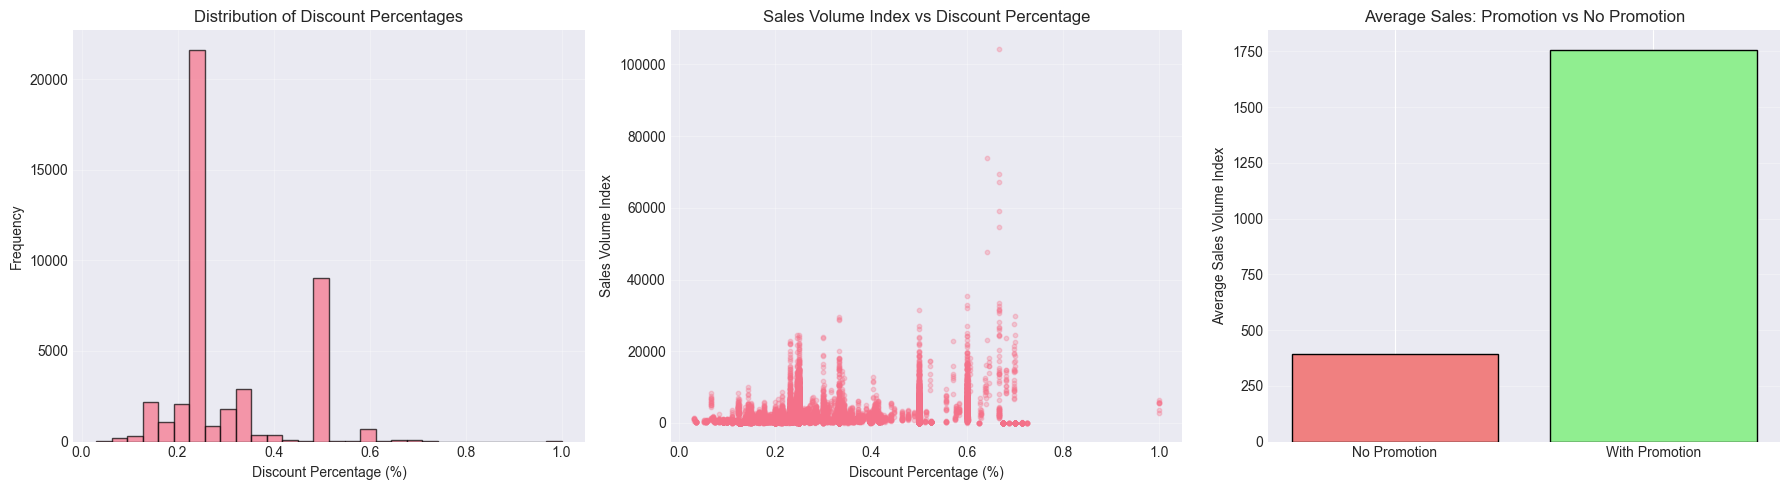

In [51]:
# Promotion impact analysis
df_master_train['has_promo'] = df_master_train['promo_id'].notna()
promo_analysis = df_master_train.groupby('has_promo').agg({
    'sales_volume_index': ['mean', 'median', 'std', 'count'],
    'discountPct': 'mean'
}).round(2)

print("=" * 60)
print("PROMOTION IMPACT ANALYSIS")
print("=" * 60)
print(promo_analysis)

# Discount percentage analysis
if df_master_train['discountPct'].notna().sum() > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Distribution of discount percentages
    discount_data = df_master_train['discountPct'].dropna()
    axes[0].hist(discount_data, bins=30, edgecolor='black', alpha=0.7)
    axes[0].set_title('Distribution of Discount Percentages')
    axes[0].set_xlabel('Discount Percentage (%)')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)
    
    # Sales vs Discount
    promo_df = df_master_train[df_master_train['discountPct'].notna()].copy()
    axes[1].scatter(promo_df['discountPct'], promo_df['sales_volume_index'], 
                   alpha=0.3, s=10)
    axes[1].set_title('Sales Volume Index vs Discount Percentage')
    axes[1].set_xlabel('Discount Percentage (%)')
    axes[1].set_ylabel('Sales Volume Index')
    axes[1].grid(True, alpha=0.3)
    
    # Compare sales with and without promotion
    promo_comparison = df_master_train.groupby('has_promo')['sales_volume_index'].mean()
    axes[2].bar(['No Promotion', 'With Promotion'], promo_comparison.values, 
               color=['lightcoral', 'lightgreen'], edgecolor='black')
    axes[2].set_title('Average Sales: Promotion vs No Promotion')
    axes[2].set_ylabel('Average Sales Volume Index')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

WEATHER VARIABLES CORRELATION WITH SALES
  Weather Variable  Correlation with Sales
2         max_temp               -0.023311
0        mean_temp               -0.021408
1         min_temp               -0.017155
6   sunshine_hours               -0.017122
3  mean_wind_speed                0.012524
5  precip_duration                0.004865
7    mean_pressure               -0.002641
4     rel_humidity                0.000819


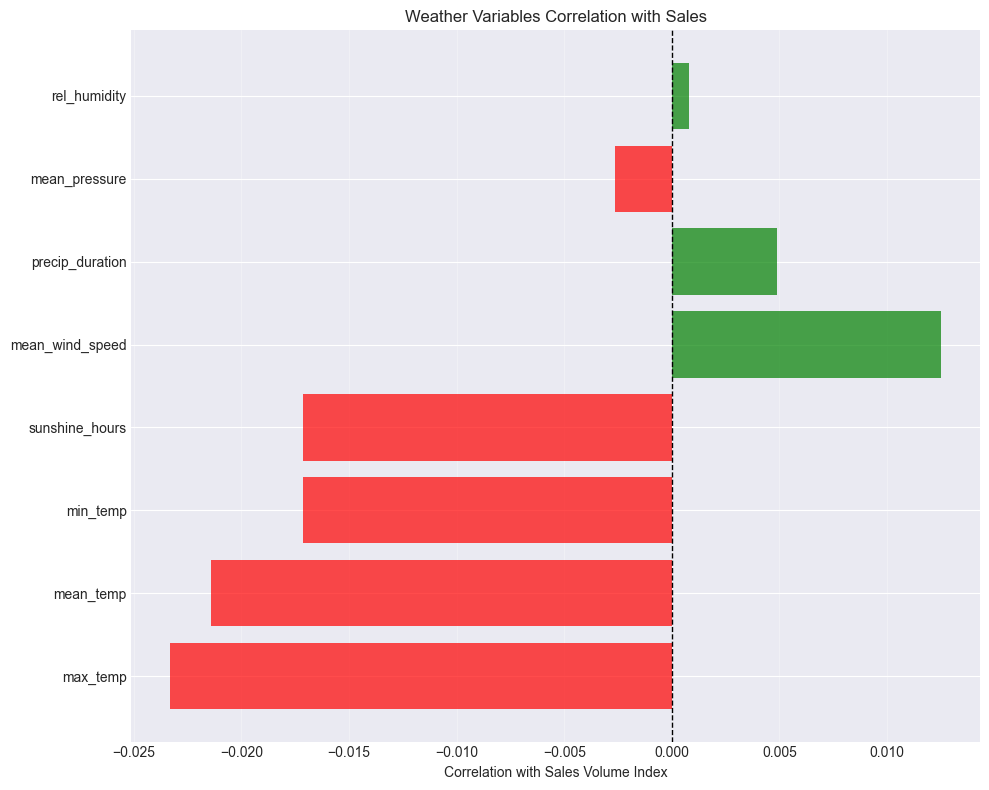

/var/folders/3y/2cjrvnx95y7dsn_lgb0h9_p00000gn/T/ipykernel_90460/1253426761.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_bin_sales = df_master_train.groupby('temp_bin')['sales_volume_index'].mean()


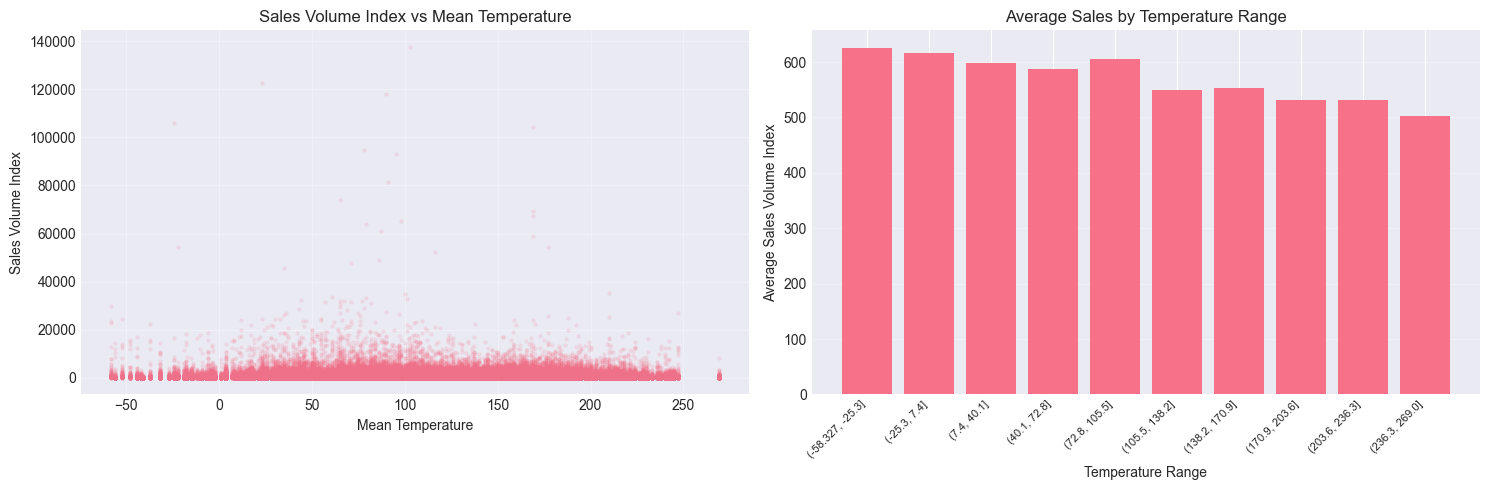

In [52]:
# Key weather variables correlation with sales
weather_vars = ['mean_temp', 'min_temp', 'max_temp', 'mean_wind_speed', 
                'rel_humidity', 'precip_duration', 'sunshine_hours', 'mean_pressure']

# Calculate correlations
weather_correlations = {}
for var in weather_vars:
    if var in df_master_train.columns:
        corr = df_master_train[var].corr(df_master_train['sales_volume_index'])
        weather_correlations[var] = corr

corr_df = pd.DataFrame(list(weather_correlations.items()), 
                       columns=['Weather Variable', 'Correlation with Sales'])
corr_df = corr_df.sort_values('Correlation with Sales', key=abs, ascending=False)

print("=" * 60)
print("WEATHER VARIABLES CORRELATION WITH SALES")
print("=" * 60)
print(corr_df)

# Visualize correlations
plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in corr_df['Correlation with Sales']]
plt.barh(corr_df['Weather Variable'], corr_df['Correlation with Sales'], color=colors, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Correlation with Sales Volume Index')
plt.title('Weather Variables Correlation with Sales')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Temperature impact on sales
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Mean temperature vs sales
axes[0].scatter(df_master_train['mean_temp'], df_master_train['sales_volume_index'], 
               alpha=0.1, s=5)
axes[0].set_title('Sales Volume Index vs Mean Temperature')
axes[0].set_xlabel('Mean Temperature')
axes[0].set_ylabel('Sales Volume Index')
axes[0].grid(True, alpha=0.3)

# Binned temperature analysis
df_master_train['temp_bin'] = pd.cut(df_master_train['mean_temp'], bins=10)
temp_bin_sales = df_master_train.groupby('temp_bin')['sales_volume_index'].mean()
axes[1].bar(range(len(temp_bin_sales)), temp_bin_sales.values)
axes[1].set_xticks(range(len(temp_bin_sales)))
axes[1].set_xticklabels([str(x) for x in temp_bin_sales.index], rotation=45, ha='right', fontsize=8)
axes[1].set_title('Average Sales by Temperature Range')
axes[1].set_xlabel('Temperature Range')
axes[1].set_ylabel('Average Sales Volume Index')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()